# Analyzing and comparing different venues in Budapest and Prague

### Author: Imre Kovacs, imre.kov@gmail.com

## 1. Introduction

Budapest and Prague are two quickly developing cities in East Europe. Their sizes are not too different, Budapest is the 10th largest city in the EU by population, while Prague is the 14th. Both cities are tourist hotspots, welcoming millions of visitors every year. 
They have similarities in their history, too, as both have been the part of the Austro-Hungarian Empire and both has been ruled by communist governments in the second half of the 20th century. <br>
After 1990, Budapest and Prague became fast growing capitals, with more and more business opening, quickly learning how to adjust to the new capitalist era.

### 1.1 Some background information

Budapest is the capital of Hungary, with population of 1.7 million people, living both sides of the Danube. The city has 23 districts, its overall size is 525.2 km2. Budapest's GDP is above Hungarian and EU average, 52,770 USD per capita. <br>
In 2018, the city welcomed around 12 million international visitors. 

Prague is the capital of the Czech Republic, population is 1.3 million people, at the banks for the Vltava river. The city has 22 districts, its size is 496 km2. Prague's GDP is above the national average with 62500 USD per capita. <br>
In 2017, the city welcomed 8.4 million international visitors.

As seen from the data above, both cities are well above their own national and EU average in terms of financial availabilites. Their per capita GDP can be compared e.g. to Berlin, which has a thriving hospitality sector. The same can be said about these two cities, too, both because of their own population and the incoming tourists' needs. 

### 1.2 Problem: Comparing the different hospitality venues of the two cities

As it has been explained before, the two cities has a lot in common, both in their history and actual development. As per Tripadvisor, Budapest has around 1200 restaurants and around 300 cafes. Prague has almost 2000 resturants and 600 coffee places. <br>
I would like to compare the two cities, mainly their districts, based on their hospitality venues (resturants, coffee shops). I would like to find similarities between the cities' districts, but also would like to find major differences, if there are any. <br>
I will visualize the findings, both in lists and maps, trying to make it even more understandable.

### 1.3 Key objectives of analyzing the data set

1, Which are the most similar districts of Budapest and Prague, based on their venues? <br>
2, Which are the biggest differencies between districts of the two cities? <br>
3, Which are the districts with the least and most venues? <br>

## 2. Data Acquisition and sources

### 2.1 Data sources

I will use the following data for this project:

- Districts of Budapest and Prague, with their latitudes and longitudes. <br>
  Source: Wikipedia, I will create two CSV files for them, as they are not available at one page for easy automated scrapping.

- Resturants and coffee shops in each district of the cities <br>
  Source: Foursquare API

### 2.2 Methodology

- I will load the districts geo data from the mentioned CSV files
- Using Foursquare API, I will get all the needed venues for each district
- I will create clusters of the districts based on their hospitality venues and their ratings
- The clusters will be visualized on maps using Folium and in lists, pointing out their similarities and differences

## 3. Implementation

### Importing all needed libraries

In [3]:
import pandas as pd
import numpy as np
import urllib.request
from pandas.io.json import json_normalize
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes
import folium
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans

import matplotlib.cm as cm
import matplotlib.colors as colors

import requests

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



### Reading geo data from csv files

In [4]:
geo_data_path_prague = "Prague_neighborhoods.csv"
geo_data_prague=pd.read_csv(geo_data_path_prague, encoding='utf-8-sig')

geo_data_path_budapest = "Budapest_neighborhoods.csv"
geo_data_budapest=pd.read_csv(geo_data_path_budapest, encoding='utf-8-sig')


### Initializing FourSquare API

In [5]:
CLIENT_ID = 'XXX' # removed for privacy
CLIENT_SECRET = 'XXX' # removed for privacy
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IDNMEIDJDG1ST3GTMBZVED40QPPO2P0B45GDK31ECXIBMGEC
CLIENT_SECRET:A5WKLJEPGDZWEFUPJ0OOZ4XKNHXQBLQIBGB4QYOZTQMB0CKV


### Creating method to get venues, filtered only to food venues

In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4d4b7105d754a06374d81259'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Requesting both cities' venues from FourSquare

In [ ]:
food_data_prague = getNearbyVenues(names=geo_data_prague['Neighborhood'],
                                   latitudes=geo_data_prague['Latitude'],
                                   longitudes=geo_data_prague['Longitude']
                                  )

In [ ]:
food_data_budapest = getNearbyVenues(names=geo_data_budapest['Neighborhood'],
                                   latitudes=geo_data_budapest['Latitude'],
                                   longitudes=geo_data_budapest['Longitude']
                                  )

### Creating method to define most common venues

In [9]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Creating one hot coded version for both cities

In [10]:
# one hot encoding
budapest_onehot = pd.get_dummies(food_data_budapest[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
budapest_onehot['Neighborhood'] = food_data_budapest['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns_budapest = [budapest_onehot.columns[-1]] + list(budapest_onehot.columns[:-1])
budapest_onehot = budapest_onehot[fixed_columns_budapest]

budapest_grouped = budapest_onehot.groupby('Neighborhood').mean().reset_index()

In [11]:
# one hot encoding
prague_onehot = pd.get_dummies(food_data_prague[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
prague_onehot['Neighborhood'] = food_data_prague['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns_prague = [prague_onehot.columns[-1]] + list(prague_onehot.columns[:-1])
prague_onehot = prague_onehot[fixed_columns_prague]

prague_grouped = prague_onehot.groupby('Neighborhood').mean().reset_index()

### Calculating top 10 venue types for both cities

In [12]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_budapest = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_budapest['Neighborhood'] = budapest_grouped['Neighborhood']

for ind in np.arange(budapest_grouped.shape[0]):
    neighborhoods_venues_sorted_budapest.iloc[ind, 1:] = return_most_common_venues(budapest_grouped.iloc[ind, :], num_top_venues)

In [13]:
neighborhoods_venues_sorted_prague = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_prague['Neighborhood'] = prague_grouped['Neighborhood']

for ind in np.arange(prague_grouped.shape[0]):
    neighborhoods_venues_sorted_prague.iloc[ind, 1:] = return_most_common_venues(prague_grouped.iloc[ind, :], num_top_venues)

### Setting up k-means clustering

In [14]:
# set number of clusters
kclusters = 5

budapest_grouped_clustering = budapest_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(budapest_grouped_clustering)

In [15]:
prague_grouped_clustering = prague_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans.fit(prague_grouped_clustering)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

### Merging geodata with clusters to be able to visualize on map

In [16]:
neighborhoods_venues_sorted_budapest.insert(0, 'Cluster Labels', kmeans.labels_)

budapest_merged = geo_data_budapest

budapest_merged = budapest_merged.join(neighborhoods_venues_sorted_budapest.set_index('Neighborhood'), on='Neighborhood')

budapest_merged.dropna(subset=['Cluster Labels'],axis=0,inplace=True)

In [17]:
neighborhoods_venues_sorted_prague.insert(0, 'Cluster Labels', kmeans.labels_)

prague_merged = geo_data_prague

prague_merged = prague_merged.join(neighborhoods_venues_sorted_prague.set_index('Neighborhood'), on='Neighborhood')

### Getting the coordination of the cities

In [18]:
address='Budapest'
geolocator=Nominatim(user_agent="TN_explorer")
location=geolocator.geocode(address)
latitude_budapest=location.latitude
longitude_budapest=location.longitude
print("The geographic coordinates of Budapest are {},{}:".format(latitude_budapest,longitude_budapest))

The geographic coordinates of Budapest are 47.4983815,19.0404707:


In [19]:
address='Prague'
geolocator=Nominatim(user_agent="TN_explorer")
location=geolocator.geocode(address)
latitude_prague=location.latitude
longitude_prague=location.longitude
print("The geographic coordinates of Prague are {},{}:".format(latitude_prague,longitude_prague))

The geographic coordinates of Prague are 50.0874654,14.4212535:


### Visualizing the clusters on the city maps

#### Prague

In [21]:
# create map
map_clusters_prague = folium.Map(location=[latitude_prague, longitude_prague], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(prague_merged['Latitude'], prague_merged['Longitude'], prague_merged['Neighborhood'], prague_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [float(lat), float(lon)],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters_prague)
       
map_clusters_prague

#### Budapest

In [22]:
# create map
map_clusters_budapest = folium.Map(location=[latitude_budapest, longitude_budapest], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(budapest_merged['Latitude'], budapest_merged['Longitude'], budapest_merged['Neighborhood'], budapest_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [float(lat), float(lon)],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters_budapest)
       
map_clusters_budapest

#### Getting the districts with the most and least number of venues

In [23]:
venues_number_prague = food_data_prague['Neighborhood'].value_counts()

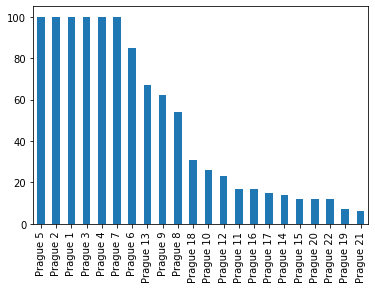

In [24]:
venues_number_prague.plot.bar()

In [25]:
venues_number_budapest = food_data_budapest['Neighborhood'].value_counts()

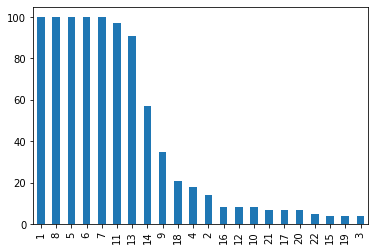

In [26]:
venues_number_budapest.plot.bar()

### Listing clusters from both city

#### Cluster 0

In [27]:
budapest_merged.loc[budapest_merged['Cluster Labels'] == 0, budapest_merged.columns[[0] + list(range(4, budapest_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Hungarian Restaurant,Café,Restaurant,Italian Restaurant,Eastern European Restaurant,Bakery,Bistro,Modern European Restaurant,Japanese Restaurant,French Restaurant
4,5,Italian Restaurant,Hungarian Restaurant,Restaurant,Eastern European Restaurant,Modern European Restaurant,Bistro,Pizza Place,Steakhouse,Café,Sandwich Place
7,8,Café,Hungarian Restaurant,Bakery,Italian Restaurant,Burger Joint,Vietnamese Restaurant,Chinese Restaurant,Pizza Place,Bistro,Diner
9,10,Hungarian Restaurant,Diner,Bakery,Restaurant,Bistro,Sandwich Place,Chinese Restaurant,Fast Food Restaurant,Donut Shop,Dumpling Restaurant
11,12,Bakery,Hungarian Restaurant,Korean Restaurant,Restaurant,Eastern European Restaurant,Pizza Place,Food Truck,Food Stand,Food Court,Food
14,15,Pizza Place,Greek Restaurant,Bakery,Food,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop
15,16,Pizza Place,American Restaurant,Café,Falafel Restaurant,Deli / Bodega,Restaurant,Bakery,Bavarian Restaurant,Doner Restaurant,Gastropub
16,17,Bakery,Restaurant,Chinese Restaurant,Café,Burger Joint,Diner,Fried Chicken Joint,French Restaurant,Food Truck,Food Stand
17,18,Eastern European Restaurant,Pizza Place,Bakery,Restaurant,Chinese Restaurant,American Restaurant,Snack Place,Middle Eastern Restaurant,Modern European Restaurant,Deli / Bodega
18,19,Restaurant,Bakery,Café,Deli / Bodega,Fried Chicken Joint,Gastropub,French Restaurant,Food Truck,Food Stand,Food Court


In [28]:
prague_merged.loc[prague_merged['Cluster Labels'] == 0, prague_merged.columns[[0] + list(range(4, prague_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Prague 1,Café,Restaurant,Italian Restaurant,Czech Restaurant,Bistro,Gastropub,Mexican Restaurant,Bakery,French Restaurant,Cuban Restaurant
1,Prague 2,Café,Vegetarian / Vegan Restaurant,Bistro,Burger Joint,Indian Restaurant,Vietnamese Restaurant,Asian Restaurant,Bakery,Mexican Restaurant,Italian Restaurant
2,Prague 3,Café,Vietnamese Restaurant,Restaurant,Bistro,Burger Joint,Italian Restaurant,Vegetarian / Vegan Restaurant,Indian Restaurant,Asian Restaurant,Pizza Place
3,Prague 4,Café,Restaurant,Pizza Place,Vietnamese Restaurant,Asian Restaurant,Czech Restaurant,Bakery,Gastropub,Italian Restaurant,Kebab Restaurant
4,Prague 5,Café,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Bakery,Restaurant,Gastropub,Czech Restaurant,Bistro,Asian Restaurant,Sushi Restaurant
5,Prague 6,Café,Bakery,Restaurant,Gastropub,Pizza Place,Vietnamese Restaurant,Italian Restaurant,Eastern European Restaurant,Modern European Restaurant,Doner Restaurant
6,Prague 7,Café,Vietnamese Restaurant,Czech Restaurant,Pizza Place,Asian Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Bistro,Bakery,Steakhouse
12,Prague 13,Bakery,Bistro,Café,Restaurant,Gastropub,Asian Restaurant,Czech Restaurant,Pizza Place,Vietnamese Restaurant,Chinese Restaurant
15,Prague 16,Bakery,Café,Pizza Place,Vietnamese Restaurant,Restaurant,Mexican Restaurant,Chinese Restaurant,Bistro,Modern European Restaurant,Doner Restaurant
17,Prague 18,Café,Restaurant,Pizza Place,Asian Restaurant,Fried Chicken Joint,Sushi Restaurant,Burger Joint,Indian Restaurant,Sandwich Place,Fast Food Restaurant


#### Cluster 1

In [29]:
budapest_merged.loc[budapest_merged['Cluster Labels'] == 1, budapest_merged.columns[[0] + list(range(4, budapest_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,2,Bakery,Bistro,Italian Restaurant,Pizza Place,Gastropub,Deli / Bodega,Hungarian Restaurant,Indian Restaurant,Middle Eastern Restaurant,Fast Food Restaurant
12,13,Restaurant,Café,Bakery,Chinese Restaurant,Pizza Place,Deli / Bodega,Diner,Eastern European Restaurant,Food Court,Indian Restaurant
20,21,Restaurant,Bakery,Burger Joint,Diner,Food Stand,Food,Pizza Place,Food Truck,French Restaurant,Food Court
21,22,Food Court,German Restaurant,Pizza Place,Food Stand,Breakfast Spot,Fish & Chips Shop,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant


In [30]:
prague_merged.loc[prague_merged['Cluster Labels'] == 1, prague_merged.columns[[0] + list(range(4, prague_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Prague 8,Restaurant,Vietnamese Restaurant,Czech Restaurant,Bakery,Pizza Place,Café,Indian Restaurant,Burger Joint,Italian Restaurant,Kebab Restaurant
8,Prague 9,Restaurant,Café,Czech Restaurant,Bakery,Chinese Restaurant,Pizza Place,Indian Restaurant,Buffet,Italian Restaurant,Gastropub
9,Prague 10,Pizza Place,Kebab Restaurant,Restaurant,Gastropub,Mexican Restaurant,Café,Sushi Restaurant,Food,Czech Restaurant,Burger Joint
19,Prague 20,Restaurant,Café,Pizza Place,Chinese Restaurant,Gastropub,Kebab Restaurant,Bakery,Burger Joint,Donut Shop,Deli / Bodega


#### Cluster 2

In [31]:
budapest_merged.loc[budapest_merged['Cluster Labels'] == 2, budapest_merged.columns[[0] + list(range(4, budapest_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,14,Bakery,Chinese Restaurant,Restaurant,Deli / Bodega,Eastern European Restaurant,Fast Food Restaurant,Hungarian Restaurant,Café,Korean Restaurant,Diner


In [32]:
prague_merged.loc[prague_merged['Cluster Labels'] == 2, prague_merged.columns[[0] + list(range(4, prague_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Prague 21,Restaurant,BBQ Joint,Bakery,Food,Wings Joint,Fast Food Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant


#### Cluster 3

In [33]:
budapest_merged.loc[budapest_merged['Cluster Labels'] == 3, budapest_merged.columns[[0] + list(range(4, budapest_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,6,Restaurant,Indian Restaurant,Italian Restaurant,Bakery,Café,Pizza Place,Thai Restaurant,Hungarian Restaurant,Eastern European Restaurant,Vietnamese Restaurant
10,11,Café,Chinese Restaurant,Pizza Place,Fast Food Restaurant,Bakery,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sandwich Place,Eastern European Restaurant,Diner


In [34]:
prague_merged.loc[prague_merged['Cluster Labels'] == 3, prague_merged.columns[[0] + list(range(4, prague_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Prague 14,Restaurant,Gastropub,Asian Restaurant,Italian Restaurant,Caucasian Restaurant,Café,Pizza Place,Eastern European Restaurant,Wings Joint,Doner Restaurant
18,Prague 19,Restaurant,Chinese Restaurant,Pizza Place,Sushi Restaurant,Donut Shop,Cuban Restaurant,Czech Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner


#### Cluster 4

In [35]:
budapest_merged.loc[budapest_merged['Cluster Labels'] == 4, budapest_merged.columns[[0] + list(range(4, budapest_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,3,Restaurant,Bakery,Fast Food Restaurant,Deli / Bodega,Fish & Chips Shop,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant
3,4,Fast Food Restaurant,Café,Gastropub,Bakery,Chinese Restaurant,Asian Restaurant,Hungarian Restaurant,Eastern European Restaurant,Restaurant,Mexican Restaurant
6,7,Restaurant,Hungarian Restaurant,Pizza Place,Thai Restaurant,Burger Joint,Italian Restaurant,Bakery,Bistro,Café,Gastropub
8,9,Café,Diner,Bakery,Chinese Restaurant,Fast Food Restaurant,Fried Chicken Joint,Hungarian Restaurant,Burger Joint,Salad Place,Pizza Place


In [36]:
prague_merged.loc[prague_merged['Cluster Labels'] == 4, prague_merged.columns[[0] + list(range(4, prague_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Prague 11,Pizza Place,Bakery,Chinese Restaurant,Czech Restaurant,Restaurant,Snack Place,Bistro,Gastropub,Turkish Restaurant,Vietnamese Restaurant
11,Prague 12,Pizza Place,Restaurant,Bistro,Asian Restaurant,Snack Place,Chinese Restaurant,Café,Cafeteria,Mediterranean Restaurant,Czech Restaurant
14,Prague 15,Pizza Place,Mexican Restaurant,Chinese Restaurant,Czech Restaurant,Restaurant,Italian Restaurant,Fast Food Restaurant,Sandwich Place,Sushi Restaurant,Burger Joint
16,Prague 17,Czech Restaurant,Chinese Restaurant,Restaurant,Fast Food Restaurant,Snack Place,Pizza Place,Caucasian Restaurant,Bakery,Sushi Restaurant,Steakhouse


#### Listing top10 venues per districts, for exploratory analysis

#### Prague

In [37]:
neighborhoods_venues_sorted_prague

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Prague 1,Café,Restaurant,Italian Restaurant,Czech Restaurant,Bistro,Gastropub,Mexican Restaurant,Bakery,French Restaurant,Cuban Restaurant
1,1,Prague 10,Pizza Place,Kebab Restaurant,Restaurant,Gastropub,Mexican Restaurant,Café,Sushi Restaurant,Food,Czech Restaurant,Burger Joint
2,4,Prague 11,Pizza Place,Bakery,Chinese Restaurant,Czech Restaurant,Restaurant,Snack Place,Bistro,Gastropub,Turkish Restaurant,Vietnamese Restaurant
3,4,Prague 12,Pizza Place,Restaurant,Bistro,Asian Restaurant,Snack Place,Chinese Restaurant,Café,Cafeteria,Mediterranean Restaurant,Czech Restaurant
4,0,Prague 13,Bakery,Bistro,Café,Restaurant,Gastropub,Asian Restaurant,Czech Restaurant,Pizza Place,Vietnamese Restaurant,Chinese Restaurant
5,3,Prague 14,Restaurant,Gastropub,Asian Restaurant,Italian Restaurant,Caucasian Restaurant,Café,Pizza Place,Eastern European Restaurant,Wings Joint,Doner Restaurant
6,4,Prague 15,Pizza Place,Mexican Restaurant,Chinese Restaurant,Czech Restaurant,Restaurant,Italian Restaurant,Fast Food Restaurant,Sandwich Place,Sushi Restaurant,Burger Joint
7,0,Prague 16,Bakery,Café,Pizza Place,Vietnamese Restaurant,Restaurant,Mexican Restaurant,Chinese Restaurant,Bistro,Modern European Restaurant,Doner Restaurant
8,4,Prague 17,Czech Restaurant,Chinese Restaurant,Restaurant,Fast Food Restaurant,Snack Place,Pizza Place,Caucasian Restaurant,Bakery,Sushi Restaurant,Steakhouse
9,0,Prague 18,Café,Restaurant,Pizza Place,Asian Restaurant,Fried Chicken Joint,Sushi Restaurant,Burger Joint,Indian Restaurant,Sandwich Place,Fast Food Restaurant


#### Budapest

In [38]:
neighborhoods_venues_sorted_budapest

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,1,Hungarian Restaurant,Café,Restaurant,Italian Restaurant,Eastern European Restaurant,Bakery,Bistro,Modern European Restaurant,Japanese Restaurant,French Restaurant
1,1,2,Bakery,Bistro,Italian Restaurant,Pizza Place,Gastropub,Deli / Bodega,Hungarian Restaurant,Indian Restaurant,Middle Eastern Restaurant,Fast Food Restaurant
2,4,3,Restaurant,Bakery,Fast Food Restaurant,Deli / Bodega,Fish & Chips Shop,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant
3,4,4,Fast Food Restaurant,Café,Gastropub,Bakery,Chinese Restaurant,Asian Restaurant,Hungarian Restaurant,Eastern European Restaurant,Restaurant,Mexican Restaurant
4,0,5,Italian Restaurant,Hungarian Restaurant,Restaurant,Eastern European Restaurant,Modern European Restaurant,Bistro,Pizza Place,Steakhouse,Café,Sandwich Place
5,3,6,Restaurant,Indian Restaurant,Italian Restaurant,Bakery,Café,Pizza Place,Thai Restaurant,Hungarian Restaurant,Eastern European Restaurant,Vietnamese Restaurant
6,4,7,Restaurant,Hungarian Restaurant,Pizza Place,Thai Restaurant,Burger Joint,Italian Restaurant,Bakery,Bistro,Café,Gastropub
7,0,8,Café,Hungarian Restaurant,Bakery,Italian Restaurant,Burger Joint,Vietnamese Restaurant,Chinese Restaurant,Pizza Place,Bistro,Diner
8,4,9,Café,Diner,Bakery,Chinese Restaurant,Fast Food Restaurant,Fried Chicken Joint,Hungarian Restaurant,Burger Joint,Salad Place,Pizza Place
9,0,10,Hungarian Restaurant,Diner,Bakery,Restaurant,Bistro,Sandwich Place,Chinese Restaurant,Fast Food Restaurant,Donut Shop,Dumpling Restaurant


#### Number of each venues per city

#### Budapest

In [57]:
venues_categories_budapest = food_data_budapest['Venue Category'].value_counts()

In [58]:
venues_budapest = venues_categories_budapest.to_frame()

In [59]:
venues_budapest

,Venue Category
Café,77
Restaurant,73
Bakery,72
Hungarian Restaurant,63
Pizza Place,49
Italian Restaurant,46
Eastern European Restaurant,41
Chinese Restaurant,38
Burger Joint,29
Diner,25


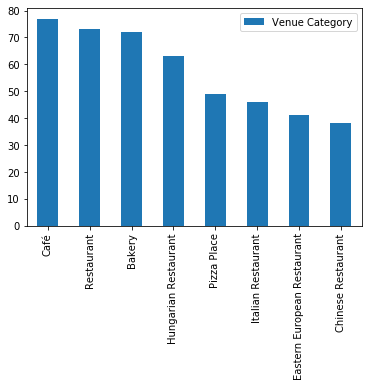

In [60]:
venues_budapest.loc[venues_budapest['Venue Category'] > 30].plot.bar()

#### Prague

In [61]:
venues_categories_prague = food_data_prague['Venue Category'].value_counts()

In [62]:
venues_prague = venues_categories_prague.to_frame()

In [63]:
venues_prague

,Venue Category
Café,178
Restaurant,116
Pizza Place,62
Bakery,55
Czech Restaurant,54
Vietnamese Restaurant,50
Bistro,38
Italian Restaurant,38
Gastropub,35
Asian Restaurant,32


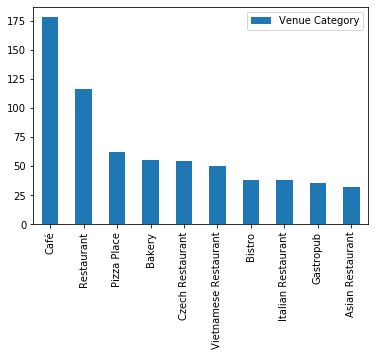

In [64]:
venues_prague.loc[venues_prague['Venue Category'] > 30].plot.bar()
